This example shows how to use a `GridInducingVariationalGP` module. This module is designed for
- When you want to use variational inference (e.g. for classification)
- When you have lots of data, and need inducing points to scale up your data
- Here it is kronecker because the input data is 2D

In this example, the function is checkerboard of 1/3x1/3 squares with labels of -1 or 1


 Here we use KISS-GP (https://arxiv.org/pdf/1503.01057.pdf) to classify

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from torch.autograd import Variable

# We make an nxn grid of training points
# In [0,1]x[0,1] spaced every 1/(n-1)
n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        # True function is checkerboard of 1/3x1/3 squares with labels of -1 or 1
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [4]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [5]:
# Our classification model is just KISS-GP run through a Bernoulli likelihood
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=10, grid_bounds=[(0, 1), (0, 1)])
        # Near-zero mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        # RBF as universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Learned mean is near-zero
        mean_x = self.mean_module(x)
        # Get predictive and scale
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Store as Gaussian
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

# Initialize classification model
model = GPClassificationModel()
# Likelihood is Bernoulli, warm predictive mean 
likelihood = BernoulliLikelihood()

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.2)
optimizer.n_iter = 0

def train():
    num_training_iterations = 200
    for i in range(num_training_iterations):
        # zero back propped gradients
        optimizer.zero_grad()
        # Make  prediction
        output = model(train_x)
        # Calc loss and use to compute derivatives
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, num_training_iterations, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
%time train()

Iter 1/200 - Loss: 214.356   log_lengthscale: 0.000
Iter 2/200 - Loss: 70.618   log_lengthscale: -0.200
Iter 3/200 - Loss: 9.959   log_lengthscale: -0.384
Iter 4/200 - Loss: 7.111   log_lengthscale: -0.556
Iter 5/200 - Loss: 13.610   log_lengthscale: -0.724
Iter 6/200 - Loss: 11.419   log_lengthscale: -0.884
Iter 7/200 - Loss: 8.134   log_lengthscale: -1.039
Iter 8/200 - Loss: 5.653   log_lengthscale: -1.185
Iter 9/200 - Loss: 5.327   log_lengthscale: -1.318
Iter 10/200 - Loss: 4.656   log_lengthscale: -1.442
Iter 11/200 - Loss: 4.360   log_lengthscale: -1.556
Iter 12/200 - Loss: 3.443   log_lengthscale: -1.660
Iter 13/200 - Loss: 3.482   log_lengthscale: -1.755
Iter 14/200 - Loss: 3.555   log_lengthscale: -1.843
Iter 15/200 - Loss: 3.392   log_lengthscale: -1.923
Iter 16/200 - Loss: 3.596   log_lengthscale: -1.997
Iter 17/200 - Loss: 2.800   log_lengthscale: -2.064
Iter 18/200 - Loss: 3.497   log_lengthscale: -2.126
Iter 19/200 - Loss: 3.094   log_lengthscale: -2.183
Iter 20/200 - Los

Iter 159/200 - Loss: 0.285   log_lengthscale: -2.900
Iter 160/200 - Loss: 0.297   log_lengthscale: -2.900
Iter 161/200 - Loss: 0.301   log_lengthscale: -2.900
Iter 162/200 - Loss: 0.293   log_lengthscale: -2.900
Iter 163/200 - Loss: 0.323   log_lengthscale: -2.900
Iter 164/200 - Loss: 0.281   log_lengthscale: -2.900
Iter 165/200 - Loss: 0.292   log_lengthscale: -2.900
Iter 166/200 - Loss: 0.293   log_lengthscale: -2.901
Iter 167/200 - Loss: 0.292   log_lengthscale: -2.901
Iter 168/200 - Loss: 0.290   log_lengthscale: -2.901
Iter 169/200 - Loss: 0.296   log_lengthscale: -2.901
Iter 170/200 - Loss: 0.304   log_lengthscale: -2.901
Iter 171/200 - Loss: 0.273   log_lengthscale: -2.901
Iter 172/200 - Loss: 0.278   log_lengthscale: -2.901
Iter 173/200 - Loss: 0.267   log_lengthscale: -2.901
Iter 174/200 - Loss: 0.291   log_lengthscale: -2.901
Iter 175/200 - Loss: 0.280   log_lengthscale: -2.901
Iter 176/200 - Loss: 0.288   log_lengthscale: -2.902
Iter 177/200 - Loss: 0.269   log_lengthscale: 

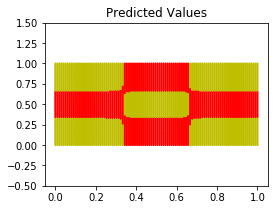

In [8]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize figiure an axis
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are 100x100 grid of [0,1]x[0,1] with spacing of 1/99
n = 100
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)
# Make binary predictions by warmping the model output through a Bernoulli likelihood
predictions = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # prob<0.5 --> label -1 // prob>0.5 --> label 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
    # Colors = yellow for 1, red for -1
    color = []
    for i in range(len(pred_labels)):
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    # Plot data a scatter plot
    ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color, s=1)
    ax.set_ylim([-0.5, 1.5])
    ax.set_title(title)
# Plot predictions
ax_plot(observed_ax, predictions, 'Predicted Values')